# Plot results using the DataFrame stored in pickle file

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.2)

### Load results:

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('scan_results_v2.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Get max chi^2
chi2Cols = [col for col in dataDF.columns.values if '.chi2' in col]
for col in chi2Cols:
    dataDF.fillna(value={col : 0.0},inplace=True)
dataDF['maxChi2'] = dataDF[chi2Cols].max(axis=1)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.
dataDF.dropna(axis=1,how='all',inplace=True)
Excluded = dataDF[dataDF['excluded'] == True]
Allowed = dataDF[dataDF['excluded'] == False]

#### Get all analyses names which exclude at least one point

In [5]:
allResults = [col for col in Excluded.columns if ('ExptRes.result' in col) and ('AnalysisID' in col)]
analysesDict = {}
for i in Excluded.index:
    for col in allResults:
        anaID = Excluded.loc[i][col]
        r = Excluded.loc[i][col.replace('AnalysisID','r')]
        dataType = Excluded.loc[i][col.replace('AnalysisID','dataType')]
        if r < 1.:
            continue
        if dataType == 'efficiencyMap':
            anaID += '-eff'
        if not anaID in analysesDict:
            analysesDict[anaID] = [i]
        else:
            analysesDict[anaID].append(i)

In [7]:
cPalette = sns.color_palette("Paired", len(analysesDict))
cMap = dict([[ana,cPalette[i]] for i,ana in enumerate(analysesDict.keys())])
color = [cMap[ana] for ana in analysesDict.keys()]

## Excluded points for each analyses:

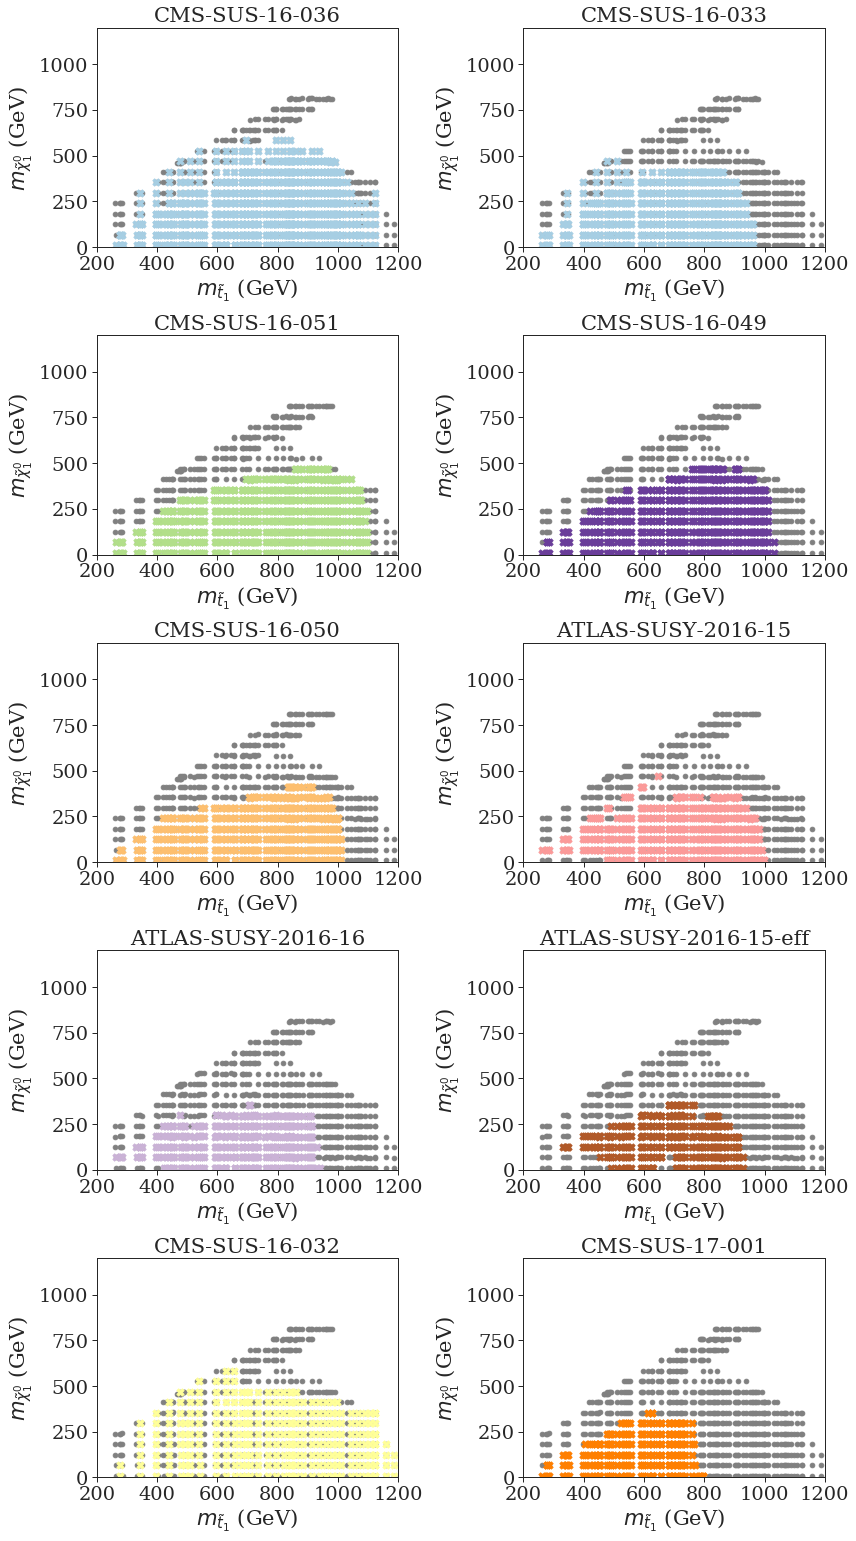

In [13]:
iplot = 1
plt.figure(figsize=(12, 25))
nplots = 10
for ana in sorted(analysesDict.keys(), key = lambda x: len(analysesDict[x]), reverse=True)[:nplots]:
    counterList = analysesDict[ana]
    plt.subplot(int(nplots/2.+1), 2, iplot)
    plt.scatter(Excluded['mass.1000006'],
                         Excluded['mass.1000022'],color='gray')
    plt.scatter(Excluded.loc[counterList,'mass.1000006'],
                         Excluded.loc[counterList,'mass.1000022'],
                         s=55,label=None,marker='X',color=cMap[ana])
    plt.xlim(200,1200)
    plt.ylim(0,1200)
    plt.xlabel(r'$m_{\tilde{t}_1}$ (GeV)')
    plt.ylabel(r'$m_{\tilde{\chi}_1^0}$ (GeV)')
    plt.title(ana)    
    iplot += 1
plt.tight_layout()
plt.show()